## importing the libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import joblib
import matplotlib.pyplot as plt


## Loading the Dataset

In [3]:
df = pd.read_excel("default of credit card clients.xls", header=1) 
df = df.drop(columns=["ID"])
# Show the first 5 rows
print(df.head())

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...       3272       3455       3261         0      1000      1000   
2      0  ...      14331      14948      15549      1518      1500      1000   
3      0  ...      28314      28959      29547      2000      2019      1200   
4      0  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0     

## Data preprocessing

In [4]:
# Define features and target
X = df.drop("default payment next month", axis=1)
y = df["default payment next month"]


## Splitting the Dataset

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Scaling the Features 

In [6]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Defining the models

In [7]:
# Step 2: Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

## Training and Evaluating the models


🔍 Logistic Regression
Accuracy     : 0.8100
Precision    : 0.6927
Recall       : 0.2369
F1 Score     : 0.3530
Confusion Matrix:
[[4549  138]
 [1002  311]]


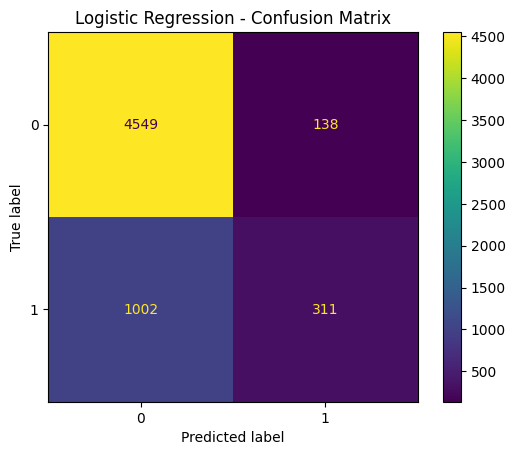


🔍 Decision Tree
Accuracy     : 0.7250
Precision    : 0.3802
Recall       : 0.4075
F1 Score     : 0.3934
Confusion Matrix:
[[3815  872]
 [ 778  535]]


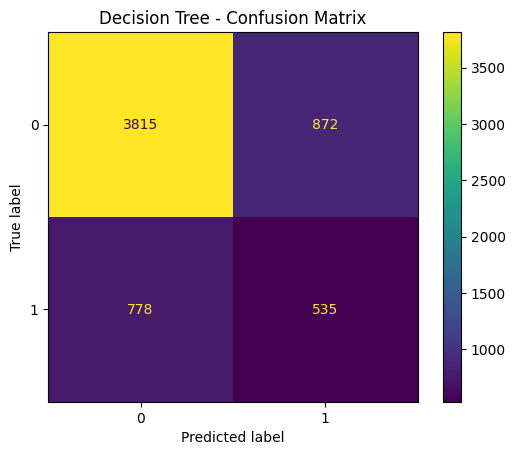


🔍 Random Forest
Accuracy     : 0.8160
Precision    : 0.6384
Recall       : 0.3671
F1 Score     : 0.4662
Confusion Matrix:
[[4414  273]
 [ 831  482]]


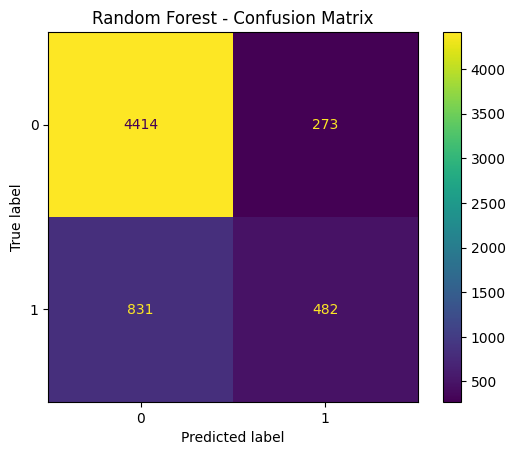

In [8]:
# Step 3: Train, predict, and evaluate
metrics = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    metrics[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

    print(f"\n🔍 {name}")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

## Selecting the model with best accuracy

In [9]:
# Step 4: Choose best model
best_model_name = max(metrics, key=lambda name: metrics[name]["Accuracy"])
print(f"\n✅ Best model: {best_model_name} with Accuracy = {metrics[best_model_name]['Accuracy']:.4f}")
best_model = models[best_model_name]

# Step 5: Retrain best model with tuned params
if best_model_name == "Random Forest":
    best_model = RandomForestClassifier(n_estimators=200, random_state=42)
elif best_model_name == "Decision Tree":
    best_model = DecisionTreeClassifier(max_depth=10, random_state=42)
elif best_model_name == "Logistic Regression":
    best_model = LogisticRegression(C=0.5, max_iter=1000)


✅ Best model: Random Forest with Accuracy = 0.8160


## Plotting the ROC curves

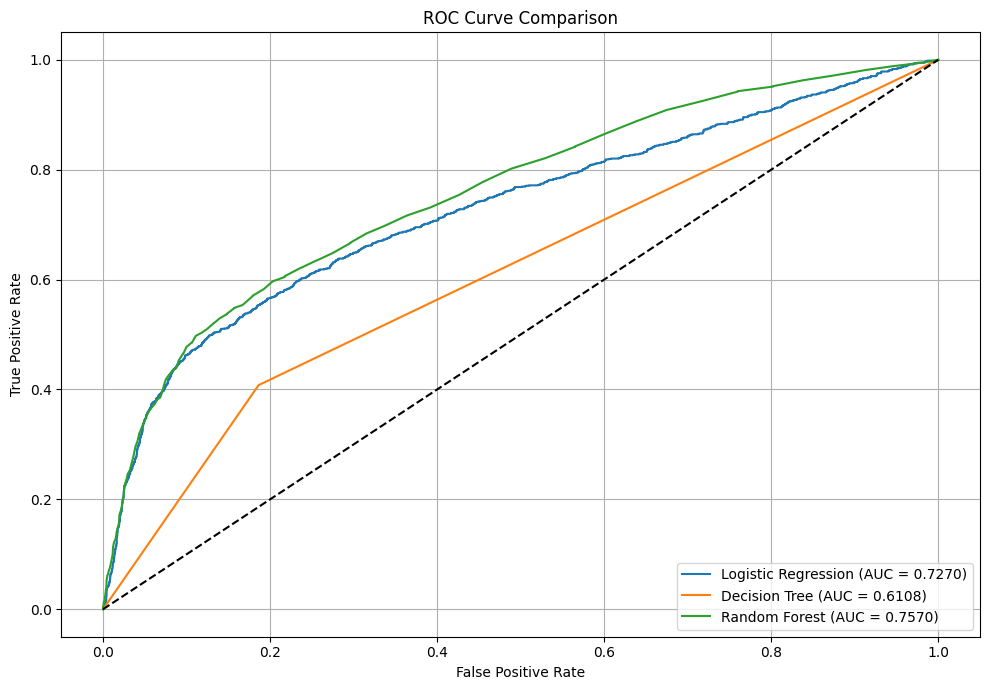

In [10]:
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

# Plot ROC curves for all models
plt.figure(figsize=(10, 7))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # Some models like SVM may not have predict_proba
        y_probs = model.decision_function(X_test_scaled)
    
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = roc_auc_score(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## Training the best model

In [11]:
# Retrain the best model
best_model.fit(X_train_scaled, y_train)

# Get predicted probabilities
final_probs = best_model.predict_proba(X_test_scaled)[:, 1]

## Setting the threshold to classify

In [12]:
# 🧠 Step 6: Use optimized threshold to classify default
# Automatically find best threshold based on F1 score
from sklearn.metrics import f1_score

best_threshold = 0.5
best_f1 = 0
for t in [i / 100 for i in range(20, 80)]:
    preds = (final_probs >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

# Apply best threshold to classify defaults
final_preds = (final_probs >= best_threshold).astype(int)

print(f"\n✅ Best Threshold for final model: {best_threshold:.2f} with F1 Score: {best_f1:.4f}")


✅ Best Threshold for final model: 0.35 with F1 Score: 0.5321


## Saving the actual and predicted results in csv file

In [13]:


# Step 7: Save predictions with probabilities and default labels
output_df = X_test.copy()
output_df["Actual"] = y_test.values
output_df["Predicted Probability"] = final_probs
output_df["Predicted Label"] = final_preds
output_df["Default Flag"] = output_df["Predicted Label"].apply(lambda x: "Default" if x == 1 else "No Default")
output_df.to_csv("credit_predictions_with_threshold.csv", index=False)

print("📁 Saved predictions with threshold in 'credit_predictions_with_threshold.csv'")



📁 Saved predictions with threshold in 'credit_predictions_with_threshold.csv'


## Saving the model

In [14]:
import joblib

# Save model and scaler with compression (level 3 is a good balance)
joblib.dump(best_model, "best_credit_model.pkl", compress=3)
joblib.dump(scaler, "credit_scaler.pkl", compress=3)

print("✅ Compressed model and scaler saved successfully.")


✅ Compressed model and scaler saved successfully.
